In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [2]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv("../data/DB2P8.csv")
DB5 = pd.read_csv("../data/DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv("../data/new_point_ids.csv")
                  
R = pd.read_csv("../data/R.csv")#DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

In [4]:
subset_ids = pd.read_csv("../data/R_ids_alpha_0.9466.csv")
R = R[R.id.isin(subset_ids.id.values)][["TAUTH"] + coeffs + ["id"]] 
R = R.reset_index(drop=True)

In [5]:
# Getting both DataFrames together: points that decreased the regression

data, regression, NP = get_regression_np(R)
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5138.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:45:13   Log-Likelihood:                 360.36
No. Observations:                2608   AIC:                            -702.7
Df Residuals:                    2599   BIC:                            -649.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3023      0.040    -57.659      0.000      -2.381      -2.224
x1             1.2706      0.024     53.537      0.000       1.224       1.317
x2             0.1475      0.021      7.063      0.000       0.107       0.188
x3            -0.0679      0.015     -4.574      0.000      -0.097      -0.039
x4            -0.5974      0.012    -48.104      0.000      -0.622      -0.573
x5             0.9466      0.038     25.201      0.000       0.873       1.020
x6             0.2388      0.039      6.081      0.000       0.162       0.316
x7            -0.2790      0.050     -5.532      0.000      -0.378      -0.180
x8             0.0969      0.031      3.144      0.002       0.036       0.157
==============================================================================
Omnibus:                        0.529   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.585
Skew:                           0.024   Prob(JB):                        0.746
Kurtosis:                       2.945   Cond. No.                         54.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
influence = regression.get_influence()
infl_summary = influence.summary_frame()

## DFBETAs Analysis to `R_ids_alpha_0.9466.csv`

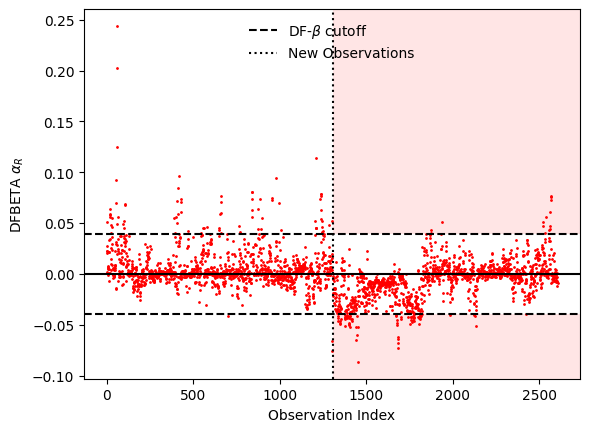

In [7]:
dfbeta_cutoff =  2/(NP[0])**(0.5)
DBβ_αR = infl_summary["dfb_x5"]

plt.scatter(list(range( len(R)+len(DB2) )), DBβ_αR.values, s=1, c="r")
plt.axhline(dfbeta_cutoff, c="k", ls="--", label="DF-$\\beta$ cutoff")
plt.axhline(-dfbeta_cutoff, c="k", ls="--")
plt.axhline(0, c="k")
plt.axvline( data[len(DB2P8):].iloc[0].name, c="k", ls=":", label="New Observations")
plt.xlabel("Observation Index")
plt.ylabel("DFBETA $\\alpha_R$")
plt.legend(loc="upper center", frameon=False)


left, bottom, width, height = (data[len(DB2):].iloc[0].name, 
                               -dfbeta_cutoff, 
                               len(data), 
                               min(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (data[len(DB2):].iloc[0].name, 
                               dfbeta_cutoff, 
                               len(data), 
                               max(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect);

In [8]:
infl_DB5 = DBβ_αR.iloc[len(DB2):]
upper_pts_αR = infl_DB5[(infl_DB5 >=  dfbeta_cutoff)].index
lower_pts_αR = infl_DB5[(infl_DB5 <= -dfbeta_cutoff)].index

infl_pts_αR = list(upper_pts_αR) + list(lower_pts_αR)
id_infl_pts_αR = data.iloc[infl_pts_αR]["id"].values

In [9]:
# Getting both DataFrames together: influential | maximizes
R_αR_infl =  R[R.id.isin(id_infl_pts_αR)]

data_infl_αR, regression_infl_αR, NP_infl_αR = get_regression_np(R_αR_infl)
regression_infl_αR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     3736.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:45:20   Log-Likelihood:                 290.96
No. Observations:                1399   AIC:                            -563.9
Df Residuals:                    1390   BIC:                            -516.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7409      0.053    -51.978      0.000      -2.844      -2.637
x1             0.9858      0.028     34.828      0.000       0.930       1.041
x2             0.2485      0.028      8.876      0.000       0.194       0.303
x3             0.2194      0.022      9.991      0.000       0.176       0.262
x4            -0.6026      0.015    -39.132      0.000      -0.633      -0.572
x5             1.6742      0.053     31.652      0.000       1.570       1.778
x6             0.2879      0.046      6.240      0.000       0.197       0.378
x7             0.2002      0.059      3.366      0.001       0.083       0.317
x8             0.1607      0.036      4.473      0.000       0.090       0.231
==============================================================================
Omnibus:                       50.085   Durbin-Watson:                   0.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.622
Skew:                          -0.161   Prob(JB):                     2.88e-26
Kurtosis:                       4.383   Cond. No.                         46.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Getting both DataFrames together: influential | minimizes
R_αR_not_infl =  R[~R.id.isin(id_infl_pts_αR)]

data_not_infl_αR, regression_not_infl_αR, NP_not_infl_αR = get_regression_np(R_αR_not_infl)
regression_not_infl_αR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5431.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:45:20   Log-Likelihood:                 449.32
No. Observations:                2519   AIC:                            -880.6
Df Residuals:                    2510   BIC:                            -828.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3152      0.039    -59.498      0.000      -2.391      -2.239
x1             1.2167      0.024     51.123      0.000       1.170       1.263
x2             0.1458      0.021      6.916      0.000       0.104       0.187
x3            -0.0174      0.015     -1.170      0.242      -0.046       0.012
x4            -0.6060      0.012    -49.828      0.000      -0.630      -0.582
x5             1.0530      0.038     27.785      0.000       0.979       1.127
x6             0.2465      0.039      6.331      0.000       0.170       0.323
x7            -0.1658      0.050     -3.318      0.001      -0.264      -0.068
x8             0.0973      0.030      3.210      0.001       0.038       0.157
==============================================================================
Omnibus:                        3.112   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                3.035
Skew:                           0.081   Prob(JB):                        0.219
Kurtosis:                       3.052   Cond. No.                         55.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Influential Pts Analysis to `data`: `R_ids_alpha_0.9576.csv`

In [11]:
infl_summary

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,dfb_x6,dfb_x7,dfb_x8,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.019078,-0.032062,0.021581,0.007375,0.004512,0.022595,-0.006546,0.025835,-0.009000,0.000527,1.392119,0.002443,0.068886,1.392370,0.068899
1,0.020640,-0.034943,0.023037,0.003561,0.012326,0.020613,-0.008638,0.026505,-0.009981,0.000622,1.479267,0.002551,0.074808,1.479606,0.074825
2,0.018279,-0.018177,0.018840,0.009069,-0.021324,0.022937,0.003869,0.021470,-0.004296,0.000269,0.937635,0.002747,0.049208,0.937613,0.049207
3,0.035236,-0.046846,0.038450,0.026425,-0.029791,0.050697,0.000932,0.049334,-0.011157,0.001208,2.022285,0.002652,0.104277,2.023488,0.104339
4,0.024317,-0.043835,0.027993,0.008449,0.013369,0.027717,-0.010266,0.034110,-0.012075,0.000907,1.762171,0.002623,0.090362,1.762885,0.090399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,0.023098,0.001883,-0.030395,0.013488,0.011954,-0.006641,-0.020738,0.008822,0.000397,0.000612,0.741252,0.009923,0.074209,0.741188,0.074203
2604,0.020388,0.004132,-0.028345,0.005707,0.012040,-0.011646,-0.006423,0.003893,-0.005153,0.000576,0.759582,0.008906,0.072005,0.759520,0.071999
2605,0.009321,0.000357,-0.005548,0.003407,-0.004530,0.000957,-0.000589,0.004865,0.000418,0.000047,0.219139,0.008749,0.020587,0.219099,0.020583
2606,0.013943,0.003576,-0.021902,0.006622,0.009923,-0.008333,-0.008408,0.002507,-0.003746,0.000300,0.529885,0.009523,0.051958,0.529811,0.051951


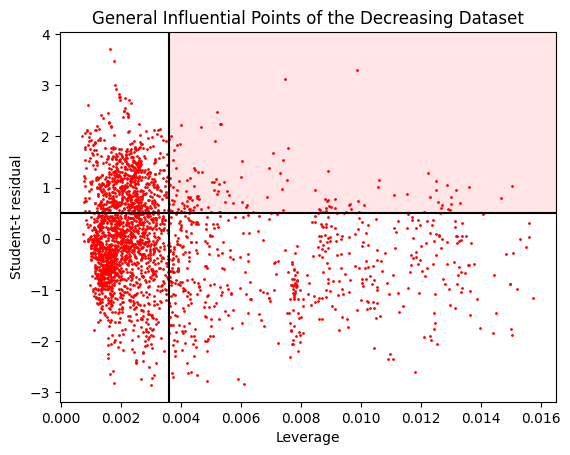

In [12]:
student_resid = influence.resid_studentized_external
leverage = influence.hat_matrix_diag
cutoff_leverage = (((2*NP[1])+2)/NP[0])*0.47
cutoff_student_resid = 0.51


plt.scatter(leverage, student_resid, s=1, c="r")
plt.ylabel("Student-t residual")
plt.xlabel("Leverage")
plt.axvline(cutoff_leverage, c="k")
plt.axhline(cutoff_student_resid, c="k")

left, bottom, width, height = cutoff_leverage, cutoff_student_resid, max(leverage), max(student_resid)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)
plt.title("General Influential Points of the Decreasing Dataset");

In [13]:
ge_infl = (pd.DataFrame([leverage,student_resid]).T).rename(columns={0:"leverage",1:"t_resid"})
ge_infl = ge_infl[ge_infl.leverage > cutoff_leverage]
ge_infl = ge_infl[ge_infl.t_resid  > cutoff_student_resid]

# Influential points found from DB5 dataset
ge_infl_DB5 = ge_infl[ge_infl.index  >= len(DB2)]
infl_DB5_ids = data[data.index.isin(ge_infl_DB5.index)].id.values

In [14]:
# Getting both DataFrames together | influential to maximize

R_infl =  R[R.id.isin( infl_DB5_ids )]

data_infl, regression_infl, NP_infl = get_regression_np(R_infl)
regression_infl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     5698.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:45:20   Log-Likelihood:                 560.98
No. Observations:                1357   AIC:                            -1104.
Df Residuals:                    1348   BIC:                            -1057.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7937      0.043    -64.814      0.000      -2.878      -2.709
x1             0.8412      0.025     33.679      0.000       0.792       0.890
x2             0.2505      0.025     10.191      0.000       0.202       0.299
x3             0.3703      0.018     20.050      0.000       0.334       0.407
x4            -0.6329      0.013    -50.423      0.000      -0.658      -0.608
x5             1.9974      0.045     44.491      0.000       1.909       2.085
x6             0.3309      0.040      8.272      0.000       0.252       0.409
x7             0.5173      0.050     10.311      0.000       0.419       0.616
x8             0.1627      0.030      5.433      0.000       0.104       0.221
==============================================================================
Omnibus:                       20.812   Durbin-Watson:                   0.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.173
Skew:                          -0.180   Prob(JB):                     7.63e-07
Kurtosis:                       3.607   Cond. No.                         48.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Getting both DataFrames together | not influential to maximize

R_not_infl = R[~R.id.isin( infl_DB5_ids )]

data_not_infl, regression_not_infl, NP_not_infl = get_regression_np(R_not_infl)
regression_not_infl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     4990.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:45:20   Log-Likelihood:                 346.35
No. Observations:                2561   AIC:                            -674.7
Df Residuals:                    2552   BIC:                            -622.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3118      0.041    -57.053      0.000      -2.391      -2.232
x1             1.2782      0.024     53.331      0.000       1.231       1.325
x2             0.1595      0.021      7.523      0.000       0.118       0.201
x3            -0.0780      0.015     -5.155      0.000      -0.108      -0.048
x4            -0.5889      0.013    -46.133      0.000      -0.614      -0.564
x5             0.9153      0.039     23.582      0.000       0.839       0.991
x6             0.2326      0.040      5.871      0.000       0.155       0.310
x7            -0.3067      0.051     -6.004      0.000      -0.407      -0.207
x8             0.0833      0.031      2.670      0.008       0.022       0.144
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   0.574
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                1.286
Skew:                           0.048   Prob(JB):                        0.526
Kurtosis:                       2.948   Cond. No.                         54.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# #points: αR: cutoff t residual  --- 0.9466
"""
1298: 0.9466: st = 1.2: leverage = *1
1298: 0.9466: st = 1: leverage = *1
1298: 0.9466: st = 0.8: leverage = *1
1297: 0.9471: st = 0.75: leverage = *1
1295: 0.9475: st = 0.7: leverage = *1
1293: 0.9475: st = 0.7: leverage = *0.98
1296: 0.9467: st = 0.8: leverage = *0.98
1296: 0.9467: st = 0.8: leverage = *0.97
1296: 0.9467: st = 0.8: leverage = *0.95
1289: 0.9433: st = 0.8: leverage = *0.6
1290: 0.9388: st = 0.8: leverage = *0.57
1289: 0.9377: st = 0.8: leverage = *0.55 
1289: 0.9377: st = 0.8: leverage = *0.52
1288: 0.9370: st = 0.8: leverage = *0.51 
1284: 0.9337: st = 0.75: leverage = *0.51 
1280: 0.9312: st = 0.7: leverage = *0.51
1278: 0.9283: st = 0.6: leverage = *0.51
1265: 0.9244: st = 0.55: leverage = *0.51 
1256: 0.9210: st = 0.5: leverage = *0.51 
1257: 0.9208: st = 0.51: leverage = *0.51 

1247: 0.9197: st = 0.51: leverage = *0.45 *********
1251: 0.9153: st = 0.51: leverage = *0.47


1287: 0.9380: st = 0.8: leverage = *0.5 
1270: 0.9458: st = 0.8: leverage = *0.4
"""; 

In [17]:
len(R_not_infl) # points that gave 0.9576 from previous analysis

1251

In [18]:
#R_not_infl[["id"]].to_csv("../data/R_ids_alpha_0.9153.csv", index=False)